In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import git
from datetime import datetime
repo = git.Repo("./", search_parent_directories=True)
homedir = repo.working_dir

In [2]:
df_jhu = pd.read_csv(f"{homedir}/data/us/aggregate_jhu.csv")
df_berk = pd.read_csv(f"{homedir}/data/us/aggregate_berkeley.csv")

In [3]:
# Get rid of the aggregate country data
df_jhu = df_jhu.drop([0])
df_jhu['FIPS'] = df_jhu['FIPS'].map(lambda f : str(f))

In [4]:
def alter(fips):
    if len(fips) == 4:
        return '0' + fips
    return fips
df_jhu['FIPS'] = df_jhu['FIPS'].map(alter)
df_jhu = df_jhu.set_index('FIPS')
df_jhu['fips'] = df_jhu.index.map(lambda s : int(s))

In [11]:
for col in df_jhu.columns.values:
    print(col)
    print(df_jhu[col].isna().sum())

State
0
Area_Name
0
Rural-urban_Continuum Code_2013
52
Urban_Influence_Code_2013
52
Economic_typology_2015
130
POP_ESTIMATE_2018
0
N_POP_CHG_2018
79
Births_2018
79
Deaths_2018
79
NATURAL_INC_2018
79
INTERNATIONAL_MIG_2018
79
DOMESTIC_MIG_2018
79
NET_MIG_2018
79
RESIDUAL_2018
79
GQ_ESTIMATES_2018
79
R_birth_2018
79
R_death_2018
79
R_NATURAL_INC_2018
79
R_INTERNATIONAL_MIG_2018
79
R_DOMESTIC_MIG_2018
79
R_NET_MIG_2018
79
Less than a high school diploma 2014-18
0
High school diploma only 2014-18
0
Some college or associate's degree 2014-18
0
Bachelor's degree or higher 2014-18
0
Percent of adults with less than a high school diploma 2014-18
0
Percent of adults with a high school diploma only 2014-18
0
Percent of adults completing some college or associate's degree 2014-18
0
Percent of adults with a bachelor's degree or higher 2014-18
0
POVALL_2018
80
CI90LBAll_2018
80
CI90UBALL_2018
80
PCTPOVALL_2018
80
CI90LBALLP_2018
80
CI90UBALLP_2018
80
POV017_2018
80
CI90LB017_2018
80
CI90UB017_2018


In [65]:
features = ['State', 'Area_Name','POP_ESTIMATE_2018', 'Area in square miles - Land area', 'Density per square mile of land area - Population', 'Total_Male', 'Total_Female', 'Total_age0to17', 
            'Total_age18to64','Total_age65plus', 'Active Physicians per 100000 Population 2018 (AAMC)', 'Active General Surgeons per 100000 Population 2018 (AAMC)',
           'Non-profit hospital beds per 1000 people (2019)'
           , 'Total hospital beds per 1000 people (2019)', 'Total nurse practitioners (2019)',
           'Total Hospitals (2019)', 'transit_scores - population weighted averages aggregated from town/city level to county', 'fips']

In [73]:
import math
df = df_jhu[features]
df = df[df.fips % 1000 != 0]
df = df[df.State != 'PR']   # peurto rico has some weird data...
print(np.where(df['transit_scores - population weighted averages aggregated from town/city level to county'].map(lambda v: math.isnan(v))))
print(df.shape)
df.iloc[397]

(array([ 397,  412,  436,  504,  538,  548, 1026, 1184, 1187, 1189, 1216,
       1597, 1609, 1830, 1851, 1868, 1870, 2311, 2491, 2512, 2812, 2866,
       2924, 2926, 2944, 2945, 2992, 2993, 2994, 2995, 2996, 2997, 2998,
       2999, 3000, 3001, 3002, 3003, 3004, 3005, 3006, 3007, 3008, 3009,
       3010, 3011, 3012, 3013, 3014, 3015, 3016, 3017, 3018, 3019, 3020,
       3021, 3022, 3023, 3024, 3025, 3026, 3027, 3028, 3029, 3030, 3031,
       3032, 3033, 3034, 3035, 3036, 3037, 3038, 3039, 3040, 3041, 3042,
       3043, 3044, 3045, 3046]),)
(3142, 18)


State                                                                                               GA
Area_Name                                                                                  Bibb County
POP_ESTIMATE_2018                                                                               153095
Area in square miles - Land area                                                                249.76
Density per square mile of land area - Population                                                622.8
Total_Male                                                                                       71847
Total_Female                                                                                     81248
Total_age0to17                                                                                   37623
Total_age18to64                                                                                  91596
Total_age65plus                                                          

In [43]:
# gets list of all fips numbers
def get_fips():
    Y = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
    return set(Y.fips.values)

def get_date(datestr, formatstr='%Y-%m-%d'):
    return datetime.strptime(datestr, formatstr)

In [77]:
cum_deaths = pd.read_csv(f"{homedir}/data/us/covid/deaths.csv")
cum_deaths = cum_deaths.iloc[1:]
def get_cum_deaths(fips):
    idx = cum_deaths.index[cum_deaths['countyFIPS'] == fips].values[0]
    county_deaths = cum_deaths.loc[cum_deaths['countyFIPS'] == fips]
    dates = pd.to_datetime(county_deaths.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    for i in range(4, len(county_deaths.columns)):
        y.append(county_deaths.loc[idx,county_deaths.columns[i]])
    return X, y

cum_cases = pd.read_csv(f"{homedir}/data/us/covid/confirmed_cases.csv")
cum_cases = cum_cases.iloc[1:]
def get_cum_cases(fips):
    idx = cum_cases.index[cum_cases['countyFIPS'] == fips].values[0]
    county_cases = cum_cases.loc[cum_cases['countyFIPS'] == fips]
    dates = pd.to_datetime(county_cases.columns[4:].values).map(lambda dt : str(dt))
    X = np.array([(get_date(d[:10]) - get_date('2020-01-01')).days for d in dates])
    y = []
    for i in range(4, len(county_cases.columns)):
        y.append(county_cases.loc[idx,county_cases.columns[i]])
    return X, y

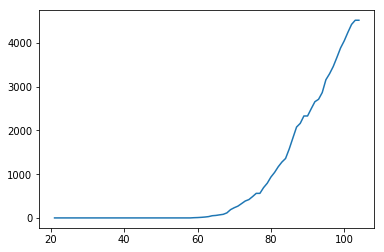

In [80]:
X, y = get_cum_cases(53033)
plt.plot(X,y)

In [81]:
NYT_counties_daily = pd.read_csv(f"{homedir}/data/us/covid/nyt_us_counties_daily.csv")
# Gets the number of deaths per day of a given county along with the time, counted in days
# since Jan 1st
def get_delta_deaths(fips, clip_zeros=True):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.deaths.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

def get_delta_cases(fips, clip_zeros=True):
    Y_county = NYT_counties_daily.loc[NYT_counties_daily['fips'] == fips, :]
    Y_county.head()
    start_date = '2020-01-01'
    Y_county['time'] =  Y_county['date'].map(lambda d : (get_date(d) - get_date('2020-02-01')).days)
    X, y = (Y_county.time.values, Y_county.cases.values)
    if not clip_zeros:
        return X, y
    for i in range(len(y)):
        if y[i] != 0:
            break
    return X[i:], y[i:]

# returns an X, y where y[i] is the number of deaths on day i divided by the running average
def get_delta_deaths_ratio(fips, clip_zeros=True, avg_period=5):
    X_raw, y_raw = get_delta_deaths(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))
def get_delta_cases_ratio(fips, clip_zeros=True, avg_period=5):
    X_raw, y_raw = get_delta_cases(fips, clip_zeros)
    y = []
    running_sum = 0.0
    running_time = 0
    for i in range(len(X_raw)):
        if y_raw[i] == 0:
            y.append(0)
        elif running_sum == 0:
            y.append(1) # if this is the first case we define the signal as 1
        else:
            avg = running_sum/running_time
            y.append(y_raw[i]/avg)
        if running_time == avg_period:
            running_sum = running_sum + y_raw[i] - y_raw[i - avg_period]
        else:
            running_sum = running_sum + y_raw[i]
            running_time = running_time + 1    
        if running_sum == 0:
            running_time = 1
    return (X_raw, np.array(y))

## Augmented Dickey Fuller Test for Stationary Time Series

In [82]:
import statsmodels.tsa.stattools as ts
adfTest = ts.adfuller(y, autolag='AIC')
dfResults = pd.Series(adfTest[0:4], index=['ADF Test Statistic','P-Value','# Lags Used','# Observations Used'])
#Add Critical Values
for key,value in adfTest[4].items():
    dfResults['Critical Value (%s)'%key] = value
print('Augmented Dickey-Fuller Test Results:')
print(dfResults)

Augmented Dickey-Fuller Test Results:
ADF Test Statistic      -0.853362
P-Value                  0.802943
# Lags Used              6.000000
# Observations Used     77.000000
Critical Value (1%)     -3.518281
Critical Value (5%)     -2.899878
Critical Value (10%)    -2.587223
dtype: float64


Conclude: time series is stationary

In [87]:
fips_list = get_fips()
stationary = 0
non_stationary = 0
for fips in fips_list:
    X, y = get_delta_deaths_ratio(fips, clip_zeros=True)
    if len(y) < 6:
        continue
    adfTest = ts.adfuller(y, maxlag=4)
    if adfTest[1] > 0.05:
            non_stationary += 1
    else:
            stationary += 1

print ("stationary %d, non-stat %d" % (stationary, non_stationary))

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
/home/sean/anaconda3/lib/python3.7/site-packages/statsmodels/base/model.py:1181: RuntimeWarning: invalid value encountered in multiply
  cov_p = self.normalized_cov_params * scale


stationary 694, non-stat 200


## ARIMA Model

/home/sean/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  


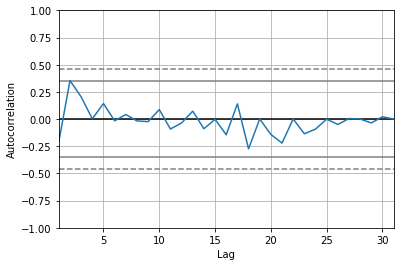

In [84]:
from statsmodels.tsa.arima_model import ARIMA
from statsmodels.tsa.stattools import pacf
from pandas.plotting import autocorrelation_plot
# some counties: King (53033), NYC (36061), Chicago (17031), LA (6037), Wayne, MI (26163)
X, y = get_delta_deaths_ratio(36061, clip_zeros=True)
autocorrelation_plot(y)

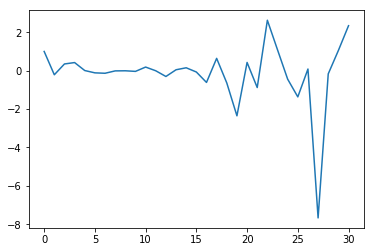

In [86]:
plt.plot(pacf(y))